In [2]:
# last edited Apr 4, 2021, by GO. 
# to do: 
 

################################################################################
# script uses 'seagrid' E grid (500 m) and a bathymetric data file to generate 
#  new bathymetric .nc file at coarser resolutions (multiples of 500 m). 
#  Based on original code provided by M Dunphy. 
#  Assumes input bathymetric file is on exact grid as 'seagrid'.
#  Output can be used by NEMO to generate a 'mesh mask'

# in: 
#    coordinates_seagrid_SalishSea2.nc - 500m coordinates, same region
#    bathymetry_201702.nc - 500m bathymetry, same region
#
# out: 
#    coordinates_seagrid_SalishSea_1500m.nc 
#    bathymetry_201702.nc

# change log: 
#    - Apr 3 2021 - 
#         issue with np.nan vs np.NaN or similar causing issues with XIOS. 
#         Set all land values to zero instead of nan.
#    - Feb 5, 2021, by GO (previously called 'Working Grid Generator')
#          - fixes to the Fraser river extension and southeast corner
#
#    - mike made improvements - Dec 29, 2020
#    - to 'decimante' a 500 m Arakawa E grid to 1 km, 1.5 km, 2 km etc grids 
#      (factors of 500 m) we can extract by skipping n cells and taking coords 
#      from previous 500 m Arakawa E grid. 
#      However, the point we extract from the 500 m grid depends on the new grid 
#      - it's either an 'f' point (even number of skipped cells, n; e.g., 1 km = 
#      2 x 500 m = even) or a 't' point (if n is odd). 

################################################################################
%matplotlib notebook

import netCDF4 as nc
import numpy as np
from helpers import writebathy, expandf # custom helper fns from MD, MEOPAR 
from helpers import gete1, gete2, writecoords, t2u, t2v, t2f
import matplotlib.pyplot as plt

res = "1500m"
km = "1500m"
gridfilename = "..//data//grid//coordinates_salishsea_{}.nc".format(res) # in 
n = 3 # e.g., 500m x n = new res
datetag = "20210406"
bathyout_filename = "..//data//bathymetry//bathy_salishsea_{}_{}.nc".format(res,datetag)
bathyout_filename_preedits = "..//data//bathymetry//bathy_salishsea_{}_before_manual_edits.nc".format(res)

def loadreduce_md(pt, n):
    c0 = '..//data//grid//etc//coordinates_seagrid_SalishSea2.nc'

    with nc.Dataset(c0) as ncid:
        if pt=='t':
            glam = ncid.variables["glamt"][0, 1::n, 1::n].filled()
            gphi = ncid.variables["gphit"][0, 1::n, 1::n].filled()
        if pt=='u':
            glam = ncid.variables["glamu"][0, 1::n, 2::n].filled()
            gphi = ncid.variables["gphiu"][0, 1::n, 2::n].filled()
        if pt=='v':
            glam = ncid.variables["glamv"][0, 2::n, 1::n].filled()
            gphi = ncid.variables["gphiv"][0, 2::n, 1::n].filled()
        if pt=='f':
            glam = ncid.variables["glamf"][0, 2::n, 2::n].filled()
            gphi = ncid.variables["gphif"][0, 2::n, 2::n].filled()
    return glam, gphi

In [3]:
#########################################################
######### DECIMATE GRID FROM 500m to 1500m ##############

# Since we're doing a 3-way reduction, we can re-use the original points and not calculate new ones
glamt, gphit = loadreduce_md('t', n)
glamu, gphiu = loadreduce_md('u', n)
glamv, gphiv = loadreduce_md('v', n)
glamf, gphif = loadreduce_md('f', n)

# Compute scaling factors (with extrapolation for the left/bottom most scaling factor)
e1t = gete1(glamu,gphiu,expandleft=True)   # Need a left u point
e1u = gete1(glamt,gphit)
e1v = gete1(glamf,gphif,expandleft=True)   # Need a left f point
e1f = gete1(glamv,gphiv)
#
e2t = gete2(glamv,gphiv,expanddown=True)   # Need a lower v point
e2u = gete2(glamf,gphif,expanddown=True)   # Need a lower f point
e2v = gete2(glamt,gphit)
e2f = gete2(glamu,gphiu)

# Output slices
NY,NX = glamt.shape
J,I = slice(0,NY), slice(0,NX-1)


writecoords(gridfilename,
            glamt[J,I],glamu[J,I],glamv[J,I],glamf[J,I],
            gphit[J,I],gphiu[J,I],gphiv[J,I],gphif[J,I],
            e1t[J,I],e1u[J,I],e1v[J,I],e1f[J,I],
            e2t[J,I],e2u[J,I],e2v[J,I],e2f[J,I])

In [4]:
##########################################################
############### DECIMATE AND EDIT BATHY ##################

# --------------------------------------------------------------------------------
# 1) get the grid centres (t points) for new grid
with nc.Dataset(gridfilename) as ncid:
    glamt = ncid.variables["glamt"][0, :, :].filled()
    gphit = ncid.variables["gphit"][0, :, :].filled()

# --------------------------------------------------------------------------------
# 2) get depths from 500 m bathy file
with nc.Dataset('..//data//bathymetry//etc//bathymetry_201702.nc') as nc_b_file:
    a = nc_b_file.variables["Bathymetry"][:, :].filled()

# --------------------------------------------------------------------------------
# 3) 'land mask' from 500 m bathy
mask = a.copy()
mask[mask > 0] = 1

# --------------------------------------------------------------------------------
# 4) create new grid taking mean of surrounding cells
a2 = np.zeros(glamt.shape)
m2 = np.zeros(glamt.shape)
for j in range(a2.shape[0]):
    for i in range(a2.shape[1]):
        i1, i2 = 3*i, 3*i+3
        j1, j2 = 3*j, 3*j+3

        bvals = a[j1:j2, i1:i2]   # extract 3x3 box of bathy values
        a2[j,i] = np.mean(bvals)
        mvals = mask[j1:j2, i1:i2]
        m2[j,i] = np.mean(mvals)

# --------------------------------------------------------------------------------
# 5) filter new bathy grid based on % land
     # (m2 is the % of the new 1500m cell that was land in 500m version)
a2[m2 < 0.5] = 0

# --------------------------------------------------------------------------------
# 6) set min depth
a2[(a2 > 0) & (a2 < 4)] = 4

# --------------------------------------------------------------------------------
# 6a) write to file pre-edits
writebathy(bathyout_filename_preedits,glamt,gphit,a2)

def manualedits(a, n):
    # a = array of depths, 1.5 km grid
    
    # manual edits for 1.5 km bathy
    if n == 3:
        # north to south
        a[296,57] = 40 #northern fjord
        a[296,54] = 60 #northern fjord
        a[296,53] = 60 #northern fjord
        a[295,52] = 150 #northern fjord
        a[286,44] = 200 #northern fjord
        a[289,32] = 20 #hardwick
        a[289,33] = 20 #hardwick
        a[286,33] = 20 #hardwick
        a[285,30] = 20 #hardwick
        a[284,41] = 20 #west thurlow
        a[284,42] = 20 #west thurlow
        a[283,43] = 20 #west thurlow
        a[282,43] = 20 #west thurlow
        a[281,44] = 20 #west thurlow
        a[279,43] = 20 #west thurlow
        a[279,45] = 20 #west thurlow
        a[269,59] = 20 #sonora
        a[265,54] = 10 #maurelle
        a[265,57] = 20 #maurelle
        a[266,52] = 20 #quadra
        a[268,46] = 20 #quadra
        a[259,53] = 20 #quadra
        a[260,57] = 20 #read
        a[254,63] = 20 #cortes
        a[254,62] = 20 #cortes
        a[255,62] = 20 #cortes
        a[254,72] = 6 #redonda
        a[254,73] = 20 #redonda
        a[252,72] = 20 #redonda
        a[252,71] = 20 #redonda
        a[251,71] = 20 #redonda
        a[197,82] = 30 #nelson
        a[197,84] = 60 #nelson
        a[199,86] = 60 #nelson
        a[200,86] = 60 #nelson
        a[156,73] = 30 #gabriola
        a[132,72] = 100 #salt spring
        a[128,71] = 50 #salt spring
        a[123,86] = 30 #mayne
        a[146,112] = 0.0 #north fraser
        a[146,114] = 0.0 #north fraser
        a[146,113] = 0.0 #north fraser
        a[146,108] = 6 #north fraser
        a[146,109] = 6 #north fraser
        a[145,112] = 0.0 #north fraser
        a[145,115] = 0.0 #north fraser
        #a[145,108] = 10 #north fraser
        a[144,108] = 6 #north fraser
        a[144,109] = 6 #north fraser
        a[144,110] = 6 #north fraser
        a[144,111] = 6 #north fraser
        a[144,112] = 6 #north fraser
        a[144,115] = 0.0 #north fraser
        a[145,110] = 0.0 #north fraser
        a[145,111] = 0.0 #north fraser
        a[145,114] = 0.0 #north fraser
        a[144,107] = 6 #north fraser
        a[143,112] = 6 #north fraser
        a[143,113] = 6 #north fraser
        a[143,115] = 0.0 #north fraser
        a[143,116] = 0.0 #north fraser
        a[142,113] = 6 #north fraser
        a[142,114] = 6 #north fraser
        a[142,116] = 0.0 #north fraser
        a[141,116] = 0.0 #north fraser
        a[141,118] = 6 #north fraser
        a[141,120] = 6 #north fraser
        a[142,120] = 6 #north fraser
        a[136,103] = 6 #south fraser
        a[137,104] = 6 #south fraser
        a[138,109] = 10 #south fraser
        a[138,112] = 12 #south fraser
        a[139,104] = 10 #south fraser
        a[139,113] = 10 #south fraser
        a[139,114] = 10 #south fraser
        a[138,113] = 0.0 #south fraser
        a[138,117] = 0.0 #south fraser
        a[137,107] = 0.0 #south fraser
        a[137,109] = 0.0 #south fraser
        a[137,110] = 0.0 #south fraser
        a[137,113] = 0.0 #south fraser
        a[137,114] = 0.0 #south fraser
        a[137,115] = 0.0 #south fraser
        a[137,116] = 10 #south fraser
        a[137,117] = 10 #south fraser
        a[137,118] = 12 #south fraser
        a[136,116] = 0.0 #south fraser
        a[136,117] = 0.0 #south fraser
        a[136,118] = 0.0 #south fraser
        a[136,119] = 0.0 #south fraser
        a[140,119] = 6 # fraser
        a[140,125] = 0.0 # fraser
        a[141,117] = 6 # fraser
        a[141,118] = 0.0 # fraser
        a[142,118] = 0.0 # fraser
        a[142,119] = 0.0 # fraser
        a[142,120] = 0.0 # fraser
        a[141,120] = 0.0 # fraser
        a[140,120] = 0.0 # fraser
        a[140,121] = 0.0 # fraser
        a[141,121] = 0.0 # fraser
        a[140,123] = 0.0 # fraser
        a[141,123] = 0.0 # fraser
        a[142,123] = 0.0 # fraser
        a[142,122] = 0.0 # fraser
        a[141,122] = 0.0 # fraser
        a[141,124] = 0.0 # fraser
        a[140,124] = 0.0 # fraser
        a[140,125] = 0.0 # fraser
        a[141,115] = 6 # fraser
        a[141,116] = 6 # fraser
        a[142,115] = 6 # fraser
        a[140,115] = 0.0 # fraser
        a[140,116] = 0.0 # fraser
        a[140,117] = 6 # fraser
        a[140,118] = 6 # fraser
        a[138,114] = 10 # fraser
        a[138,115] = 10 # fraser
        a[138,116] = 10 # fraser
        a[138,118] = 6 # fraser
        a[138,127] = 10 # fraser
        a[138,128] = 10 # fraser
        a[138,129] = 10 # fraser
        a[138,130] = 0.0 # fraser
        a[137,129] = 10 # fraser
        a[136,129] = 10 # fraser
        a[135,129] = 0 # fraser
        a[135,130] = 10 # fraser
        a[135,131] = 10 # fraser
        a[136,131] = 10 # fraser
        a[137,131] = 10 # fraser
        a[139,112] = 10 # fraser
        a[139,117] = 0.0 # fraser
        a[139,118] = 0.0 # fraser
        a[139,121] = 10 # fraser
        a[139,122] = 10 # fraser
        a[139,123] = 10 # fraser
        a[139,124] = 10 # fraser
        a[139,125] = 10 # fraser
        a[139,126] = 10 # fraser
        a[139,130] = 6 #artificial frsr riv extension
        a[140,130] = 6 #artificial frsr riv extension
        a[141,130] = 6 #artificial frsr riv extension
        a[142,130] = 6 #artificial frsr riv extension
        a[143,130] = 6 #artificial frsr riv extension
        a[144,130] = 6 #artificial frsr riv extension
        a[145,130] = 6 #artificial frsr riv extension
        a[146,130] = 6 #artificial frsr riv extension
        a[147,130] = 6 #artificial frsr riv extension 
        a[148,130] = 6 #artificial frsr riv extension
        a[149,130] = 6 #artificial frsr riv extension
        a[150,130] = 6 #artificial frsr riv extension
        a[151,130] = 6 #artificial frsr riv extension
        a[140,129] = 6 #artificial frsr riv extension
        a[139,129] = 6 #artificial frsr riv extension
        a[136,129] = 0.0 #artificial frsr riv extension
        a[135,131] = 0.0 #artificial frsr riv extension
        a[136,131] = 0.0 #artificial frsr riv extension
        a[137,131] = 0.0 #artificial frsr riv extension
        a[138,131] = 0.0 #artificial frsr riv extension
        a[135,130] = 0.0 #artificial frsr riv extension
        a[137,129] = 0.0 #artificial frsr riv extension
        a[100,93] = 15 #shaw is
        a[99,94] = 15 #shaw is  
        a[102,81] = 15 #san juan is  
        a[102,82] = 10 #san juan is 
        a[103,82] = 10 #san juan is  
        a[104,82] = 10 #san juan is 
        a[104,83] = 10 #san juan is 
        a[94,98] = 30 #lopez is
        a[82,101] = 20 #rosario b
        a[81,101] = 20 #rosario b
        a[81,102] = 10 #rosario b
        a[33,43] = 200 #hood cnl
        a[34,44] = 200 #hood cnl
        a[24,39] = 30 #hood cnl
        a[23,41] = 30 #hood cnl
        a[23,48] = 30 #hood cnl
        a[7,59] = 30 #tacoma
        a[5,58] = 30 #tacoma
        a[8,54] = 20 #fox is
        a[28,71] = 10 #bremerton
        a[28,72] = 10 #bremerton
        a[30,72] = 10 #bremerton
        a[27,68] = 20 #bremerton
        a[26,68] = 30 #bremerton
        a[26,66] = 30 #bremerton
        a[4,31] = 30 #southwest
        a[4,32] = 30 #southwest
        a[4,33] = 30 #southwest
        a[9,31] = 10 #southwest
        a[11,39] = 10 #southwest
        a[12,39] = 10 #southwest
        a[13,40] = 10 #southwest
        a[14,41] = 10 #southwest
        a[6,35] = 10 #southwest
        a[8,35] = 10 #southwest
        a[19,50] = 10 #southwest
        a[19,49] = 10 #southwest
        a[10,68] = 10 #southwest
        a[8,30] = 10 #southwest
        a[8,29] = 10 #southwest
        a[1,46] = 10 #southwest - MD fix 20210208
    return a

# --------------------------------------------------------------------------------
# 7) apply manual edits
a3 = manualedits(a2, n)




In [ ]:
# Apr 6 --------------------------------------------------------------------------
# 8) replace all np.nan and nan with 0.0

    
    


In [ ]:
# --------------------------------------------------------------------------------
# 9) write to file
writebathy(bathyout_filename,glamt,gphit,a3)

print("success")

# Plots to check channels etc
- took from old checkbathy and plotgrids files

In [4]:
import scipy.io as sio
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from helpers import expandf, grid_angle

# grid
def load1(f):
    with nc.Dataset(f) as ncid:
        glamt = ncid.variables["glamt"][0, :, :].filled()
        gphit = ncid.variables["gphit"][0, :, :].filled()
        glamu = ncid.variables["glamu"][0, :, :].filled()
        gphiu = ncid.variables["gphiu"][0, :, :].filled()
        glamv = ncid.variables["glamv"][0, :, :].filled()
        gphiv = ncid.variables["gphiv"][0, :, :].filled()
        glamf = ncid.variables["glamf"][0, :, :].filled()
        gphif = ncid.variables["gphif"][0, :, :].filled()
    return glamt, glamu, glamv, glamf, gphit, gphiu, gphiv, gphif

#
def load2(f):
    with nc.Dataset(f) as ncid:
        e1t = ncid.variables["e1t"][0, :, :].filled()
        e1u = ncid.variables["e1u"][0, :, :].filled()
        e1v = ncid.variables["e1v"][0, :, :].filled()
        e1f = ncid.variables["e1f"][0, :, :].filled()
        e2t = ncid.variables["e2t"][0, :, :].filled()
        e2u = ncid.variables["e2u"][0, :, :].filled()
        e2v = ncid.variables["e2v"][0, :, :].filled()
        e2f = ncid.variables["e2f"][0, :, :].filled()
    return e1t,e1u,e1v,e1f,e2t,e2u,e2v,e2f

def load3(f):
    with nc.Dataset(f) as ncid:
        depth = ncid.variables["Bathymetry"][:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()

    return depth, latt, lont

# for rivers - GO
def load4(f):
    with nc.Dataset(f) as ncid:
        rorunoff = ncid.variables["rorunoff"][6, :, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()

    return rorunoff, latt, lont

# grid
def plotgrid1(f):
    glamt, glamu, glamv, glamf, gphit, gphiu, gphiv, gphif = load1(f)

    plt.figure(figsize=(7,5)); plt.clf()

    # Draw sides of every box
    glamfe, gphife = expandf(glamf, gphif)
    NY,NX = glamfe.shape
    print(glamt.shape)
    print(glamu.shape)
    print(glamf.shape)
    for j in range(NY):
        plt.plot(glamfe[j,:],gphife[j,:], 'k')
    for i in range(NX):
        plt.plot(glamfe[:,i],gphife[:,i], 'k')

    # Plot t, u, v, f points in red, green, blue, magenta    
    plt.plot(glamt, gphit, 'r.')
    plt.plot(glamu, gphiu, 'g.')
    plt.plot(glamv, gphiv, 'b.')
    plt.plot(glamf, gphif, 'm.')

    plt.tight_layout()
    plt.xlim([-123.5,-123.3])
    plt.ylim([46.84,46.95])

    #plt.savefig(f.replace(".nc","_gridpts.png"))

# grid
def plotgrid2(f):
    glamt, glamu, glamv, glamf, gphit, gphiu, gphiv, gphif = load1(f)
    e1t,e1u,e1v,e1f,e2t,e2u,e2v,e2f = load2(f)
    glamfe, gphife = expandf(glamf, gphif)
    A = grid_angle(f)
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.pcolormesh(glamfe,gphife,e1t); plt.colorbar(); plt.title("e1t (m)")
    plt.subplot(1,3,2)
    plt.pcolormesh(glamfe,gphife,e2t); plt.colorbar(); plt.title("e2t (m)")
    plt.subplot(1,3,3)
    plt.pcolormesh(glamf,gphif,A); plt.colorbar(); plt.title("angle (deg)")
   
    plt.tight_layout()
    plt.savefig(f.replace(".nc","_resolution_angle.png"))
    
# bathy
def plotgrid3(f):
    depth, latt, lont = load3(f)
    
    depth[depth==0]=np.nan
    depth[depth>0]=1
    #print(depth.shape)
    
    # can do edits below 
    # made permanent in the main create bathy above
    # north to south
    #depth[178,128] = 400 #northern fjord
#     depth[296,54] = 60 #northern fjord
#     depth[296,53] = 60 #northern fjord

    plt.figure(figsize=(8,8))

    plt.subplot(1,1,1)
    plt.pcolormesh(depth, cmap=plt.plasma()); plt.colorbar(); plt.title("depth")
    #plt.pcolormesh(depth); plt.colorbar(); plt.title("depth")
    #plt.pcolormesh(ma_rorunoff, cmap=plt.pink()); plt.title("rodepth")
    
    plt.tight_layout()
    plt.savefig(f.replace(".nc","_bathycheck.png"))

# runoff / rivers
def plotgrid4(f):
    depth, latt, lont = load3(f)
    
    # added for river runoff overlay
    rorunoff, latt2, lontt2 = load4('c:/temp/runofftools/rivers_month_202101GO.nc')
    #rorunoff[rorunoff==0]=np.nan
    #print(rorunoff.shape)
    ma_rorunoff = np.ma.masked_array(rorunoff, rorunoff == 0)
    
    depth[depth==0]=np.nan
    depth[depth>0]=1
    
    #print(depth.shape)

    plt.figure(figsize=(8,8))

    plt.subplot(1,1,1)
    plt.pcolormesh(depth, cmap=plt.plasma()); plt.colorbar(); plt.title("depth")
    #plt.pcolormesh(depth); plt.colorbar(); plt.title("depth")
    #plt.pcolormesh(ma_rorunoff, cmap=plt.pink()); plt.title("rodepth")
    
    plt.tight_layout()
    plt.savefig("C:/temp/runofftools/runoffcheck2.png")


<IPython.core.display.Javascript object>


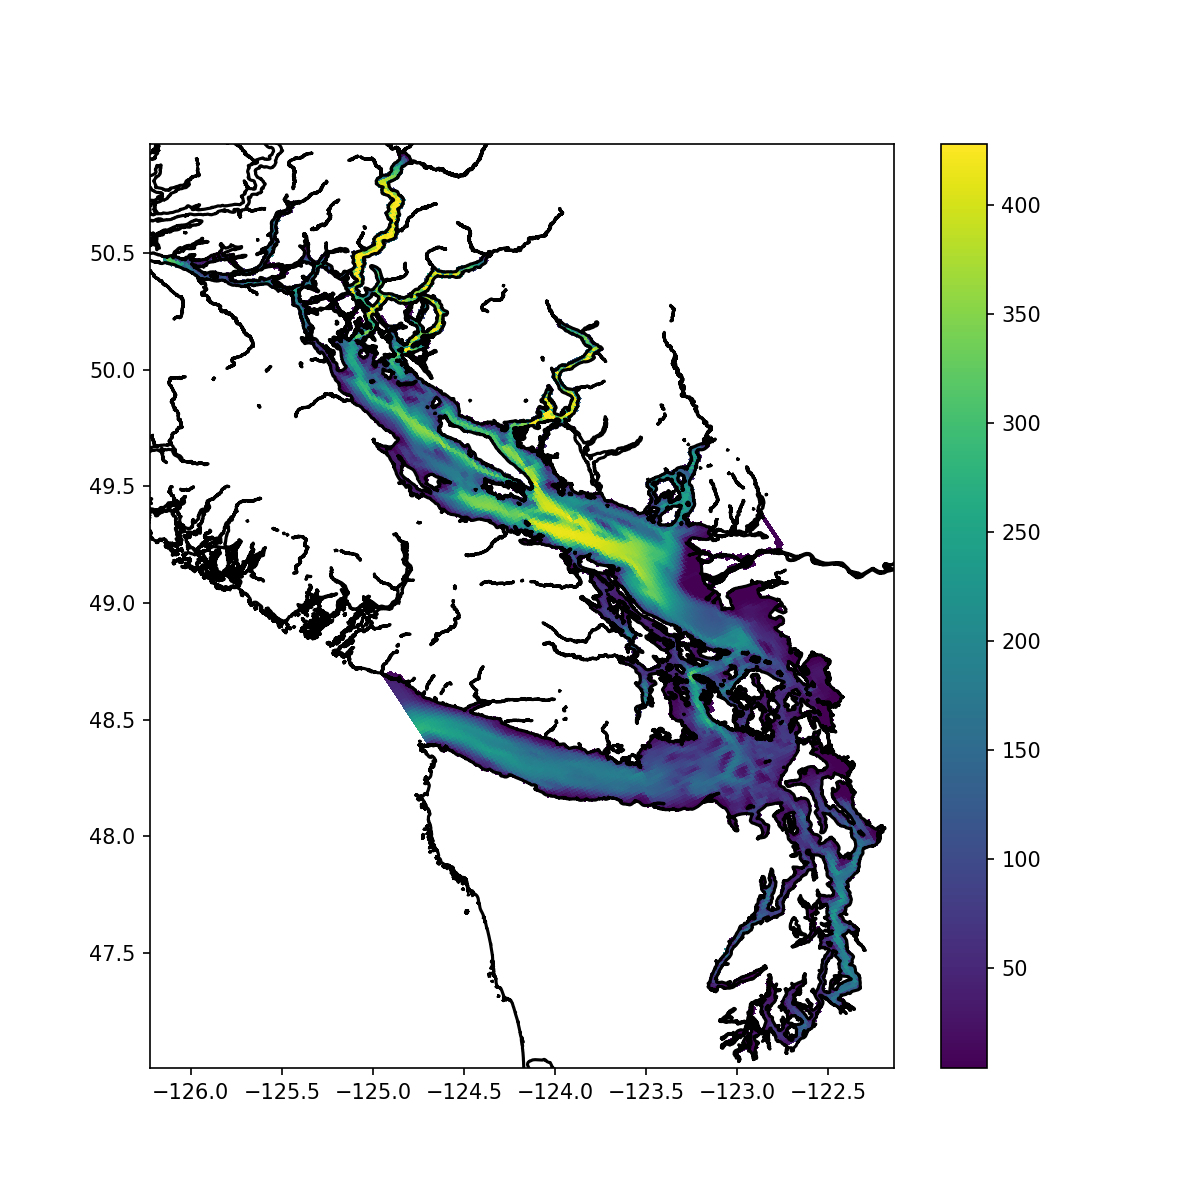

In [6]:
# #################################################################
# #################### BASIC PLOT OF BATHY ########################

gridfilename = '..//data//grid//coordinates_salishsea_1500m.nc'
#bathyfilename = 'bathy_salishsea_1500m_before_manual_edits.nc'
#bathyfilename = '..//data//bathymetry//bathy_salishsea_1500m_Dec30.nc'

with nc.Dataset(gridfilename) as ncid:
    glamt = ncid.variables["glamt"][0, :, :].filled()
    gphit = ncid.variables["gphit"][0, :, :].filled()
    glamf = ncid.variables["glamf"][0, :, :].filled()
    gphif = ncid.variables["gphif"][0, :, :].filled()
glamfe,gphife=expandf(glamf,gphif)

with nc.Dataset(bathyout_filename) as nc_b_file:
    bathy = nc_b_file.variables["Bathymetry"][:, :].filled()

bb=np.copy(bathy); bb[bb==0]=np.nan
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.pcolormesh(glamfe,gphife,bb); plt.colorbar()
# Coastlines
mfile = sio.loadmat('..//data//reference//PNW.mat')
ncst = mfile['ncst']
plt.plot(ncst[:,0],ncst[:,1],'k')

mfile2 = sio.loadmat('..//data//reference//PNWrivers.mat')
ncst2 = mfile2['ncst']
plt.plot(ncst2[:,0],ncst2[:,1],'k')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


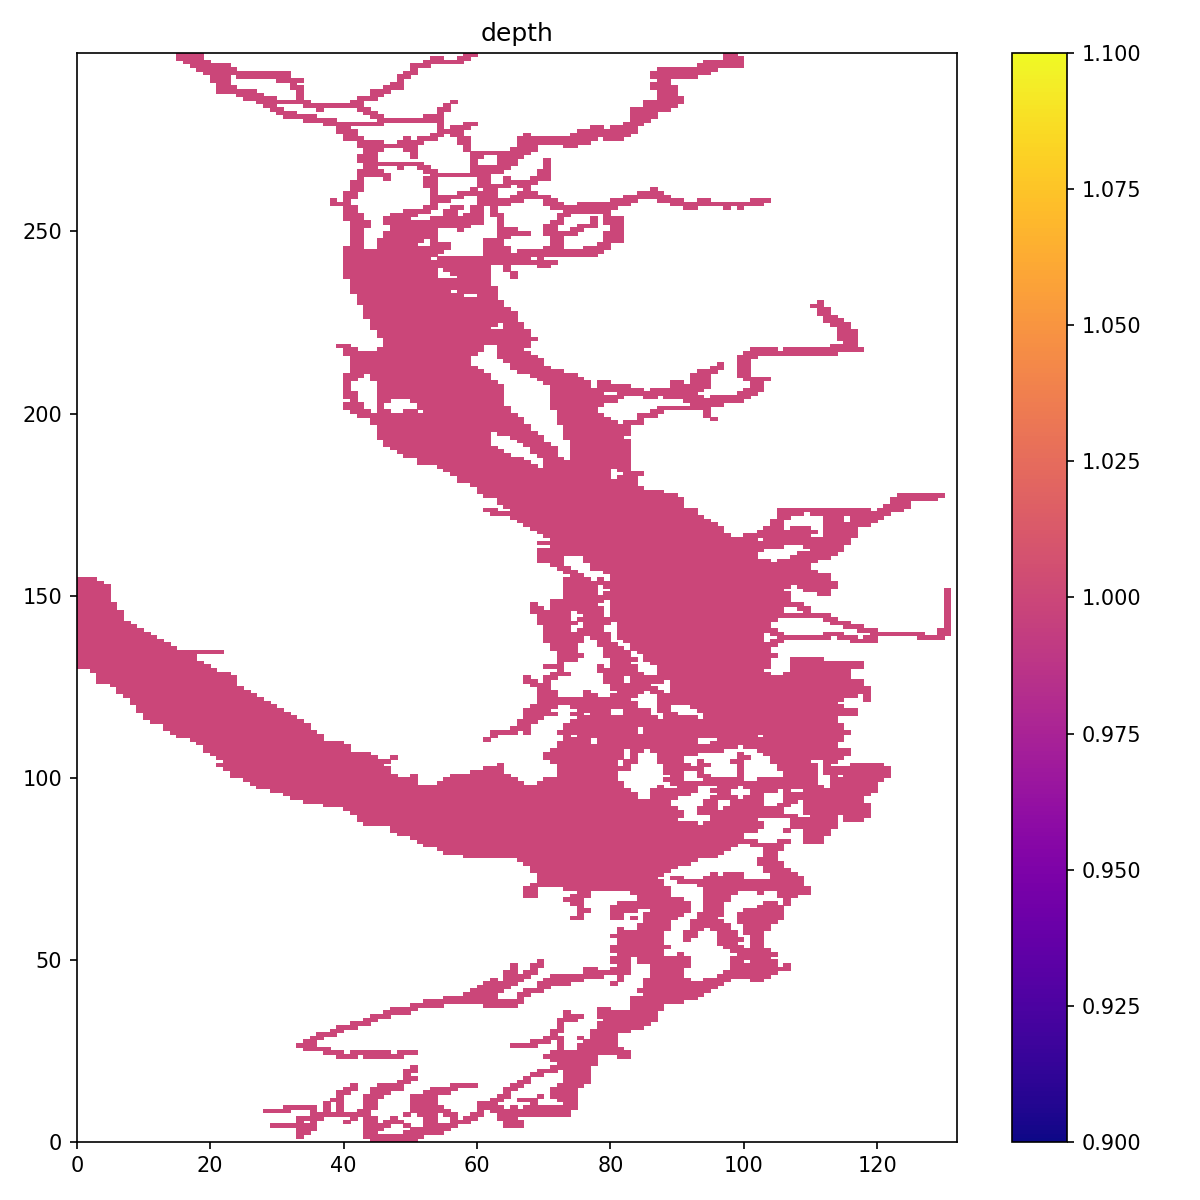

In [13]:
##########################################################
############### PLOTS TO CHECK BATHY ETC #################

# plotgrid1('coordinates_seagrid_SalishSea2.nc')
#plotgrid1('coordinates_salishsea_1km.nc')
#plotgrid1('coordinates_salishsea_1500m.nc')
#plotgrid1('coordinates_salishsea_2km.nc')
#plotgrid2('coordinates_seagrid_SalishSea2.nc')
# plotgrid2('coordinates_salishsea_1km.nc')
#plotgrid2('coordinates_salishsea_2km.nc')
#plotgrid2('coordinates_salishsea_1p5km.nc')
#plotgrid3('bathy_salishsea_1500m_Dec21.nc')
plotgrid3(bathyout_filename)
#plotgrid3('bathy_salishsea_2km.nc')

In [16]:
# junk code below

In [19]:
a = range(24)
b = a[::3]
list(b)

[0, 3, 6, 9, 12, 15, 18, 21]

In [26]:
my_list[0] = [_ for _ in 'abcdefghi']
my_list[1] = [_ for _ in 'abcdefghi']

In [21]:
my_list[0:-1]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [4]:
glamu.shape

(300, 133)

In [12]:
a[296,10]

0.0

<IPython.core.display.Javascript object>


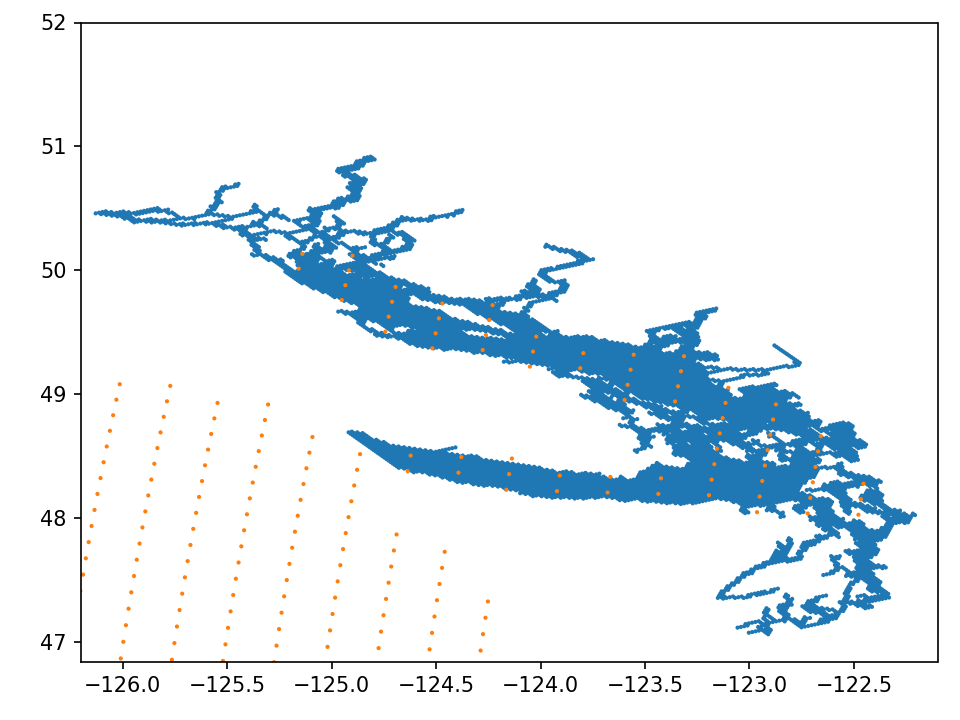

In [3]:
############################################################
### EXPLORE TWO MESHES - NEMO ORAS5 and SS1500 #############
### Apr 2021
import sys
# load mask (tmask)
def loadmask(f):
    with nc.Dataset(f) as ncid:
        tmaskutil = ncid.variables["tmaskutil"][0,:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        e1t = ncid.variables["e1t"][0,:, :].filled()
        e2t = ncid.variables["e2t"][0,:, :].filled()

    return tmaskutil, latt, lont, e1t, e2t

def plot_two_grids(f,g):

    # load ss1500mask
    tmask, latt, lont, e1t, e2t = loadmask(f)

    # load ORAS5
    tmask2, latt2, lont2, e1t2, e2t2 = loadmask(g)

    #print(tmask[:,])
    #plt.subplot(1,1,1)
    #plt.figure(figsize=(7,5)); plt.clf()
    
    plt.scatter(lont, latt, tmask)
    plt.scatter(lont2, latt2, tmask2)


    # Draw sides of every box
    #glamfe, gphife = expandf(glamf, gphif)
    #NY,NX = glamfe.shape

    #for j in range(NY):
    #    plt.plot(glamfe[j,:],gphife[j,:], 'k')
    #for i in range(NX):
    #    plt.plot(glamfe[:,i],gphife[:,i], 'k')

    # Plot t, u, v, f points in red, green, blue, magenta    
    #plt.plot(glamt, gphit, 'r.')
    #plt.plot(glamu, gphiu, 'g.')
    #plt.plot(glamv, gphiv, 'b.')
    #plt.plot(glamf, gphif, 'm.')

    #plt.plot(glamt_2, gphit_2, 'b.')

    #plt.plot(glamu, gphiu, 'g.')
    #plt.plot(glamv, gphiv, 'b.')
    #plt.plot(glamf, gphif, 'm.')
    
    plt.tight_layout()
    plt.xlim([-126.2,-122.1])
    plt.ylim([46.84,52])

    #plt.savefig(f.replace(".nc","_gridpts.png"))
    
res = "1500m"
ss1500grid = "..//data//grid//coordinates_salishsea_{}.nc".format(res) # in 
datetag = "20210406"
oras5grid = "..//data//reference//ORAS5 Mask and Bathy//mesh_mask.nc"
ss1500meshmask = "..//data//mesh mask//mesh_mask_20210406.nc"

np.set_printoptions(threshold=sys.maxsize)
plot_two_grids(ss1500meshmask, oras5grid)

9381


(299, 132)


<IPython.core.display.Javascript object>


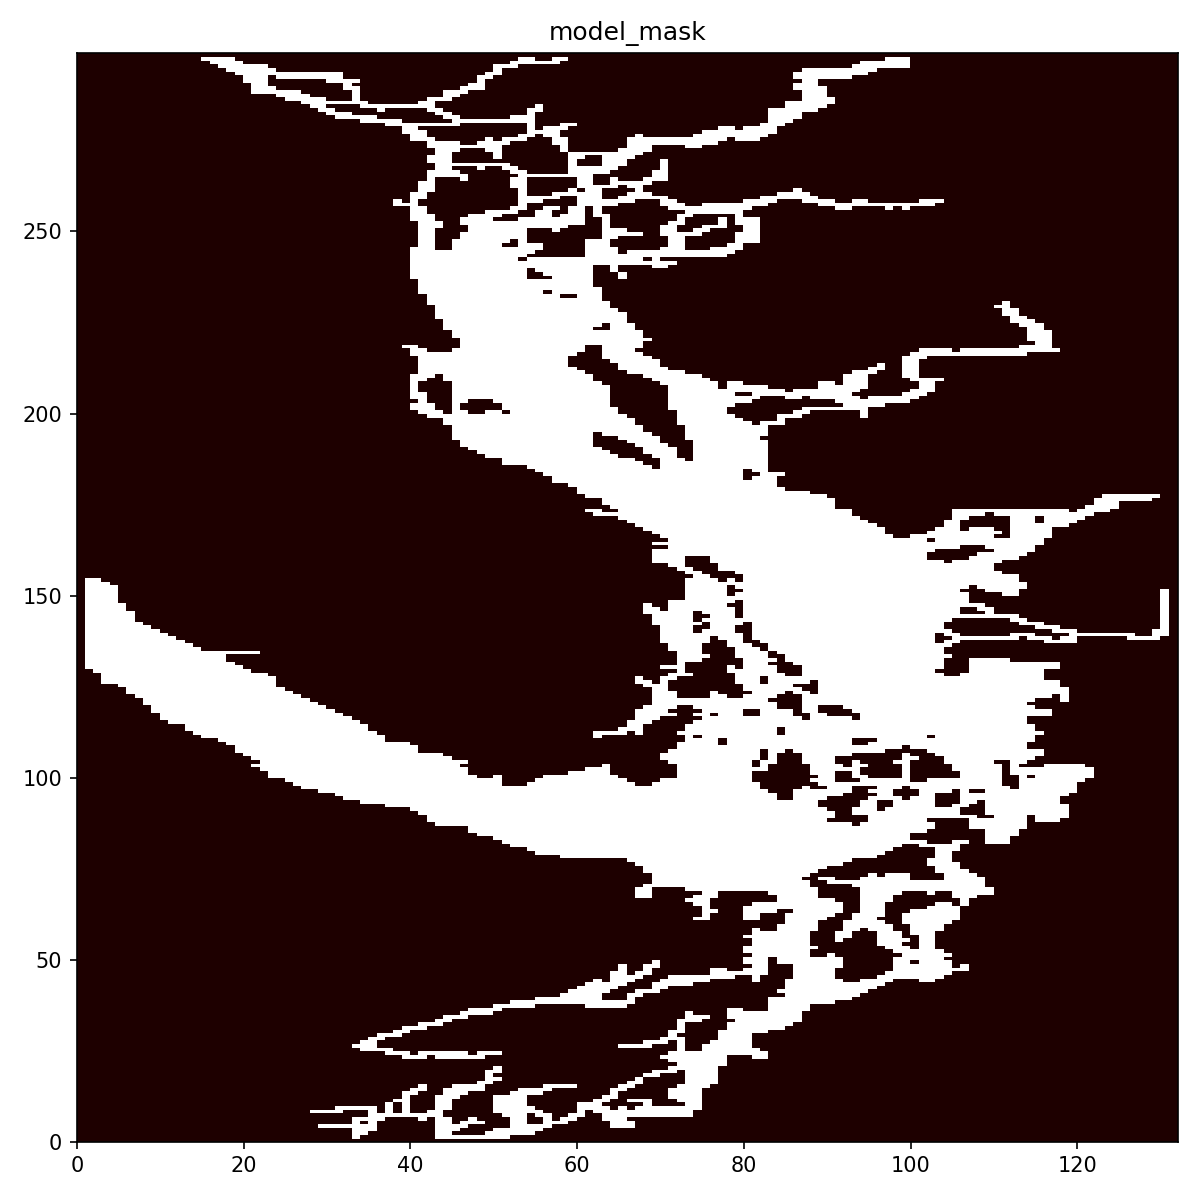

In [60]:


    tmask, latt, lont, e1t, e2t = load2(f)
      
    plt.figure(figsize=(8,8))
    plt.subplot(1,1,1)
    plt.pcolormesh(tmask[:,:], cmap=plt.pink()); plt.title("model_mask")

    plt.tight_layout()



<IPython.core.display.Javascript object>


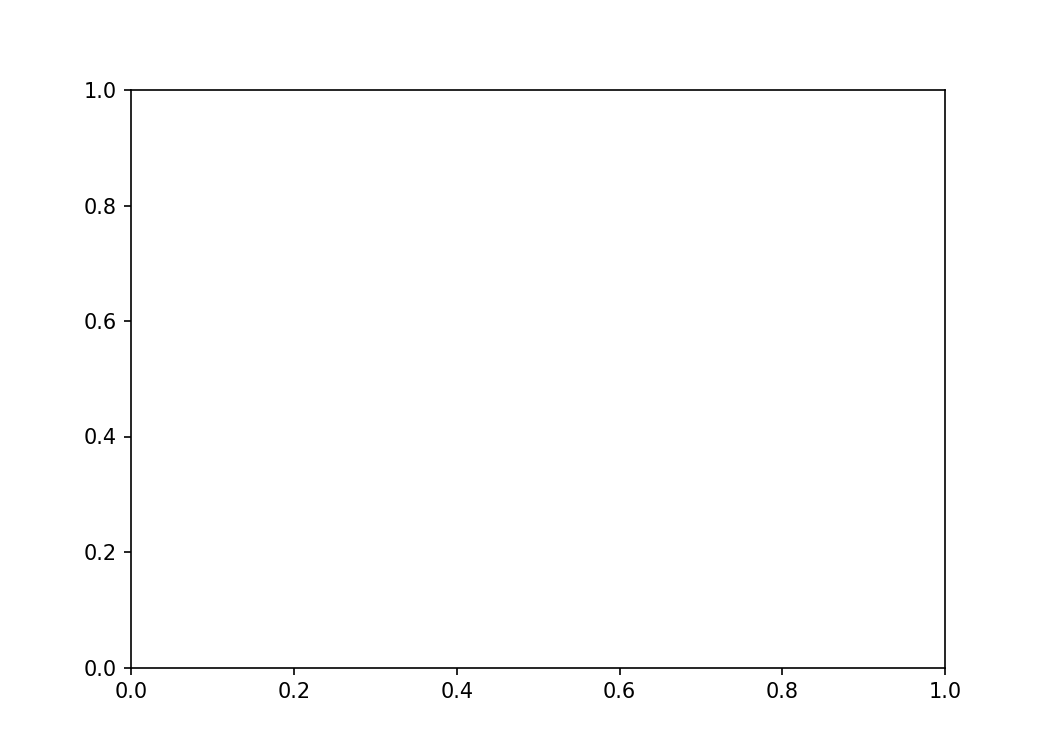

ValueError: x and y must have same first dimension, but have shapes (132,) and (299,)

In [58]:
plt.figure(figsize=(7,5)); plt.clf()
plt.plot(tmaskutil[0,:],tmaskutil[:,0], 'r.')

In [56]:
with nc.Dataset(ss1500meshmask) as ncid:
    print(tmaskutil[:,0])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
